In [292]:
from __future__ import print_function, division
from math import *
from xmlparser import *
import random
import sys
import matplotlib.pyplot as plt


__author__ = "devan, jordy, arjun"

In [293]:
# Few Utility functions
def say(*lst):
    """
    Print whithout going to new line
    """
    print(*lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

In [294]:
class O:
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'

In [295]:
class Decision(O):
    def __init__(self, name, present=False):
        O.__init__(self, name=name, present=present)

In [296]:
class Objective(O):
    #need to think of more objectives
    def __init__(self, name, low=0, high=1, do_minimize=True):
        O.__init__(self, name=name, do_minimize=do_minimize, low=low, high=high)
        
    def normalize(self, val):
        return (val - self.low)/(self.high - self.low)

In [297]:
class Point(O):
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions[:])
        new.objectives = self.objectives[:]
        return new

In [298]:
class Problem(O):
    def __init__(self, xml, BUDGET):
        O.__init__(self)
        #parse and make the feature tree and the constraint repository
        self.model_name = xml.split('.')[0]
        parser = XmlParser()
        self.tree = parser.parseFeatureTree(xml)
        self.constraintrepo = parser.parseConstraints(xml)
        
        #populate the feature map and the evaluation order
        self.feature_map = self.tree.feature_map
        self.evaluation_order = [x for x in self.feature_map.values()]
        self.evaluation_order.sort(key=lambda x : len(x.id.split("_")), reverse = True)
        
        #Fill in the decisions list and assign the cost of the features
        self.decisions = self.tree.getLeaves()
        for leaf in self.decisions:
            leaf.cost=random.randint(100,1000)
        
        #print([x.cost for x in self.decisions])
        
        #Fill in the objectives list and their boundary values
        self.objectives=[]
        self.objectives.append(Objective("constraint_violations", 0, len(self.constraintrepo.constraints)))
        self.objectives.append(Objective("#offeatures", 0, len(self.feature_map), False))
        self.objectives.append(Objective("cost_of_implementation", 0, BUDGET))
        #Add more objectives
    
    def details(self):
        print(self.model_name)
        print('Number of decisions : ', len(self.decisions))
        print('Number of Features : ',len(self.feature_map))
              
    def cleanTree(self):
        for x in self.feature_map.values():
            if not x.isLeaf():
                x.cost=0
                self.constraintrepo.setFlag(x.id, False)
                x.present = False
                
    
    def evaluate(self, point):
        if not point.objectives:
            
            violations = 0
            features = 0
            cost = 0
            
            for i,boo in enumerate(point.decisions):
                self.constraintrepo.setFlag(self.decisions[i].id, boo)
                self.decisions[i].present=boo
                
            #For all non leaf nodes calculate the cost and present/absent value
            self.cleanTree()
            for node in self.evaluation_order:
                parent = node.parent
                if parent is None:
                    continue
                if node.present:
                    parent.present=True
                    self.constraintrepo.setFlag(parent.id, True)
                    parent.cost+=node.cost
                
            #get the number of violations
            violations = self.constraintrepo.getNumOfConstraintsViolated()
            
            #get the number of features supported
            for x in self.feature_map.values():
                if x.present:
                    features+=1
            #get the total cost
            cost = self.tree.root.cost
            
            point.objectives=[violations, features, cost]
        #print('in',point.objectives)
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        #We assume all points are valid
        return True
    def generate_one(self, retries = 20):
        for _ in xrange(retries):
            point = Point([random.random()>0.5 for _ in self.decisions])
            if self.is_valid(point):
                return point
        raise RuntimeError("Exceeded max runtimes of %d" % 20)


#pr = Problem('eCommerce.xml', 10000)
#one = pr.generate_one()
#two = pr.generate_one()
#three = pr.generate_one()
#print(one.decisions)
#print(two.decisions)
#print(three.decisions)
#pr.evaluate(one)
#pr.evaluate(two)
#pr.evaluate(three)

In [299]:
def populate(problem, size):
    population = []
    for _ in range(size):
        population.append(problem.generate_one())
    return population

def crossover(mom, dad):
    n = len(mom.decisions)
    return Point(mom.decisions[:n//2] + dad.decisions[n//2:])

def mutate(problem, point, mutation_rate=0.01):
    for i, decision in enumerate(problem.decisions):
        if random.random() < mutation_rate:
            point.decisions[i] = random.random()>0.5
    return point

def cdom(problem, one, two):

    def loss(x, y):
        losses= 0
        n = min(len(x),len(y))
        for i,(x1,y1) in enumerate(zip(x,y)):
            x1 = problem.objectives[i].normalize(x1) # normalization
            y1 = problem.objectives[i].normalize(y1) # normalization
            dir = -1 if problem.objectives[i].do_minimize else 1 # adjust for direction of comparison
            losses += -1*e**(dir*(x1 - y1) / n) # raise the differences to some exponent
        return losses / n  # return mean loss
    
    x = problem.evaluate(one)
    y = problem.evaluate(two)
    lxy, lyx = loss(x, y), loss(y, x)
    return lxy < lyx

def bdom(problem, one, two):
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    dominates = False
    for i, obj in enumerate(problem.objectives):
        better = lt if obj.do_minimize else gt
        if better(objs_one[i], objs_two[i]):
            dominates = True
        elif objs_one[i] != objs_two[i]:
            return False
    return dominates

def fitness(problem, population, point, dom_func):
    return len([1 for another in population if dom_func(problem, point, another)])

def elitism(problem, population, retain_size, dom_func):
    fitnesses = []
    for point in population:
        fitnesses.append((fitness(problem, population, point, dom_func), point))
    population = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return population[:retain_size]

#problem = Problem('Linux.xml', 10000)
#population = populate(problem, 100)
#print(population)
#po=[problem.evaluate(point) for point in population]
#print(po)

In [300]:
def avg_and_variance(populations):
    size_=len(populations)
    obj_list = [p.objectives for p in populations]
    avgs = [sum([i[0] for i in obj_list])/size_,
            sum([i[1] for i in obj_list])/size_, 
            sum([i[2] for i in obj_list])/size_]

    variances = [sum((i[0]-avgs[0]) * (i[0]-avgs[0]) for i in obj_list)/size_, 
                 sum((i[1]-avgs[1]) * (i[1]-avgs[1]) for i in obj_list)/size_, 
                 sum((i[2]-avgs[2]) * (i[2]-avgs[2]) for i in obj_list)/size_]
    print(avgs)
    print(variances)
    return avgs, variances

In [301]:
def ga(problem, pop_size = 100, gens = 250, dom_func=bdom):
    population = populate(problem, pop_size)
    #print(population)
    po=[problem.evaluate(point) for point in population]
    #print(po)
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size, dom_func)
        gen += 1
    print("")
    return initial_population, population

#i,f=ga()

In [302]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    initial_z = [i[2] for i in initial_objs]
    
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    final_z = [i[2] for i in final_objs]
    
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Implemented Features")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_z, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_z, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.xlabel("Cost of Implementation")
    plt.ylabel("Implemented Features")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    
    plt.scatter(initial_x, initial_z, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_z, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Cost of Implementation")
    plt.xlabel("Constraints Violated")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

In [303]:
def plot_3D(initial, final, initialObjectives=None, finalObjectives=None):
    
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    if initialObjectives is None:
        initial_objs = [point.objectives for point in initial]
    else:
        initial_objs = initialObjectives
    if finalObjectives is None:
        final_objs = [point.objectives for point in final]
    else:
        final_objs = finalObjectives
    
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    initial_z = [i[2] for i in initial_objs]
    
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    final_z = [i[2] for i in final_objs]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    
    ax.scatter(initial_x, initial_z, initial_y, c='r', marker='o')
    ax.scatter(final_x, final_z, final_y, c='b', marker='^')

    
    ax.set_xlabel('Constraints Violated')
    ax.set_ylabel('Cost of Implementation')
    ax.set_zlabel('Supported Features')

    plt.show()

In [304]:
#Comparison of various algorithms
#For this we need the objectives to be normalized
def normalize(problem, points):
    """
    Normalize all the objectives
    in each point and return them
    """
    meta = problem.objectives
    all_objs = []
    for point in points:
        objs = []
        for i, o in enumerate(problem.evaluate(point)):
            low, high = meta[i].low, meta[i].high
            if high == low: objs.append(0);continue;
            objs.append((o-low)/(high-low))
    # TODO 3: Normalize 'o' between 'low' and 'high'; Then add the normalized value to 'objs'
        all_objs.append(objs)
    return all_objs

In [305]:
def make_reference(problem, *fronts):
    retain_size = len(fronts[0])
    reference = []
    for front in fronts:
        reference+=front
    fitnesses = []
    
    def bdom(one, two):
        dominates = False
        for i, obj in enumerate(problem.objectives):
            better = lt if obj.do_minimize else gt
            if better(one[i], two[i]):
                dominates = True
            elif one[i]!=two[i]:
                return False
        return dominates
  
    def fitness(one, dom_func):
        return len([1 for another in reference if dom_func(one, another)])

    for point in reference:
        fitnesses.append((fitness(point, bdom), point))
        
    reference = [tup[1] for tup in sorted(fitnesses, reverse=True)]
    return reference[:retain_size]

Linux
Number of decisions :  27
Number of Features :  44
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
..................................................................

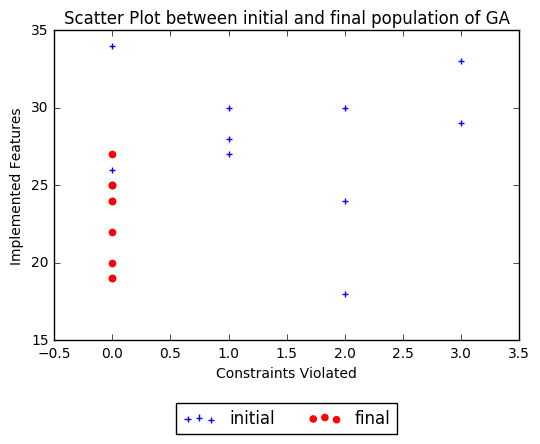

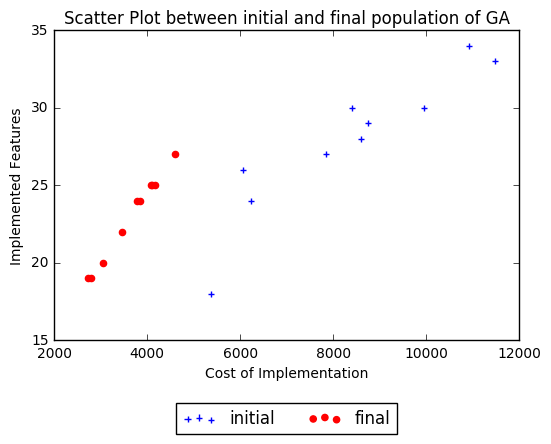

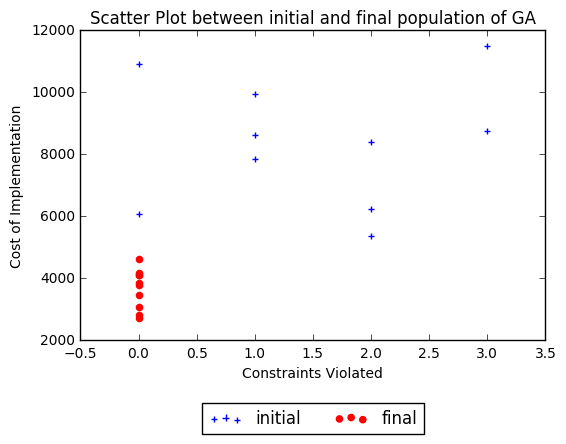

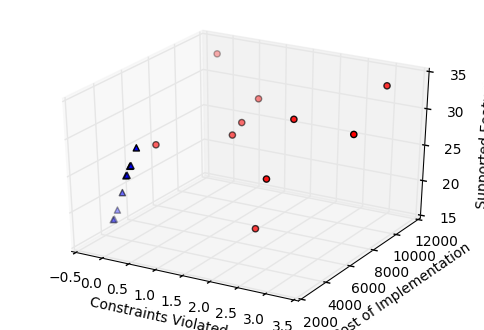

******************************************************************
[[0.0, 0.5227272727272727, 0.3332], [0.0, 0.5454545454545454, 0.3703], [0.0, 0.5227272727272727, 0.345], [0.0, 0.5227272727272727, 0.3663], [0.0, 0.5, 0.3216], [0.0, 0.5909090909090909, 0.4231], [0.0, 0.5227272727272727, 0.3666], [0.0, 0.4772727272727273, 0.3356], [0.0, 0.5227272727272727, 0.3816], [0.0, 0.5454545454545454, 0.4157]]


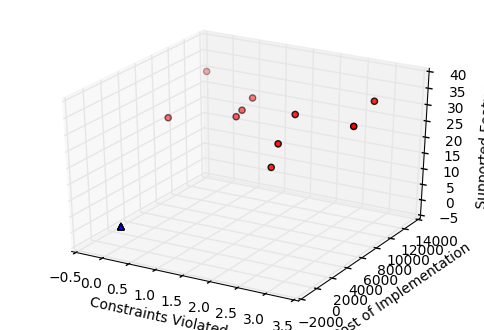

Bike
Number of decisions :  29
Number of Features :  51
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
...................................................................

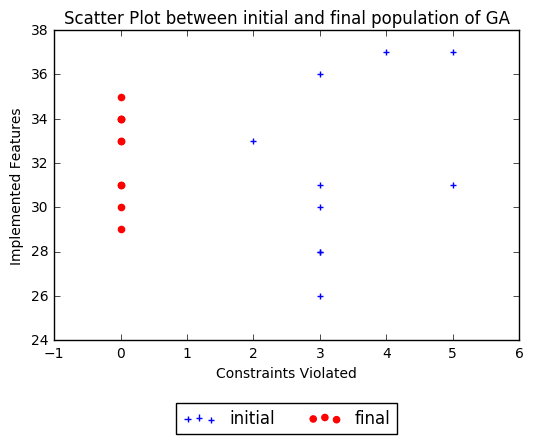

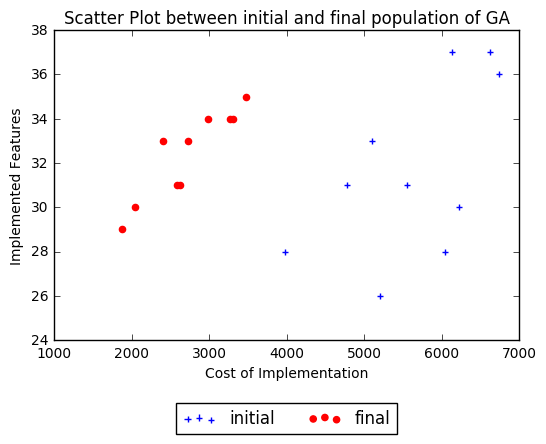

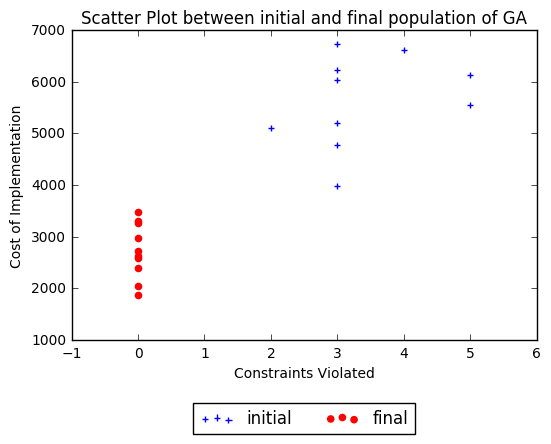

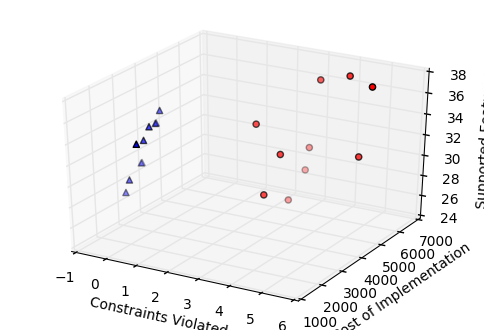

******************************************************************
[[0.05263157894736842, 0.6666666666666666, 0.2531], [0.05263157894736842, 0.6666666666666666, 0.2622], [0.05263157894736842, 0.6862745098039216, 0.2797], [0.05263157894736842, 0.6666666666666666, 0.2793], [0.05263157894736842, 0.6274509803921569, 0.2121], [0.05263157894736842, 0.6666666666666666, 0.2826], [0.05263157894736842, 0.6470588235294118, 0.2356], [0.0, 0.5882352941176471, 0.1997], [0.05263157894736842, 0.6470588235294118, 0.248], [0.05263157894736842, 0.6078431372549019, 0.2121]]


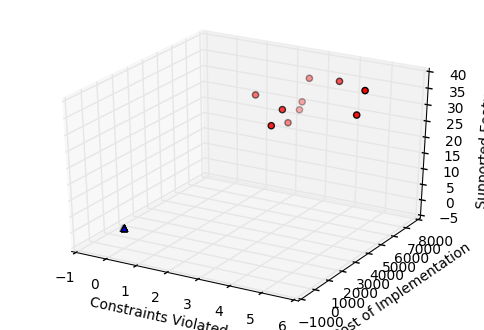

eCommerce
Number of decisions :  41
Number of Features :  68
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
..............................................................

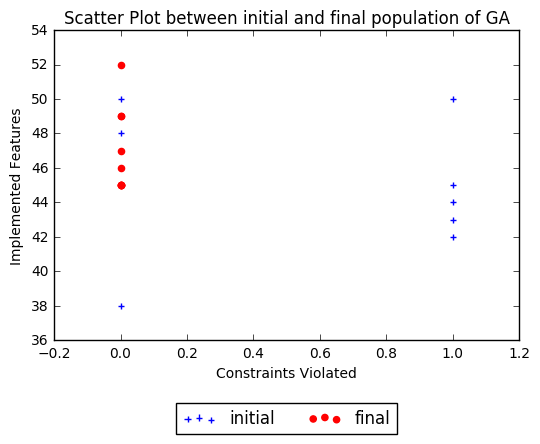

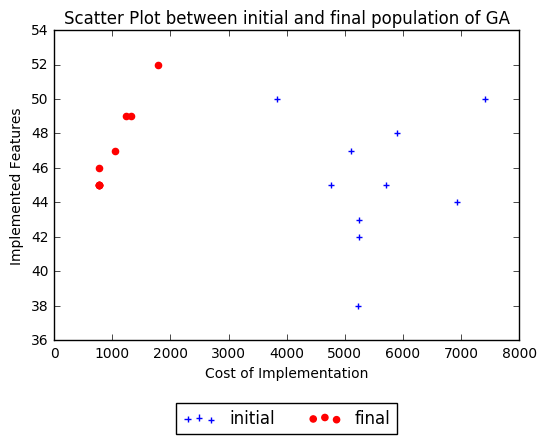

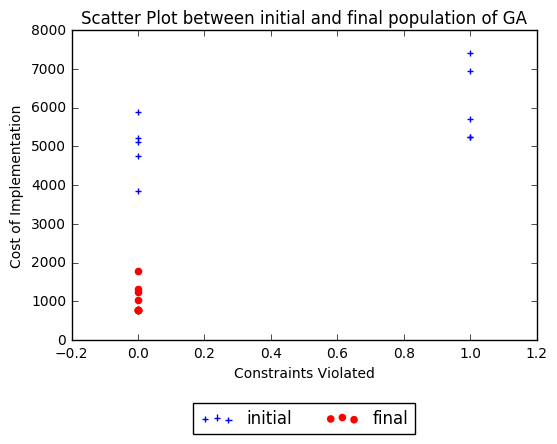

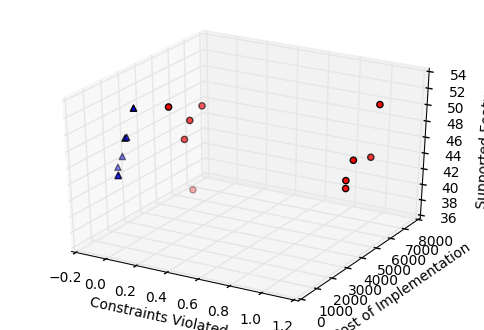

******************************************************************
[[0.0, 0.6911764705882353, 0.0765], [0.0, 0.7205882352941176, 0.1225], [0.0, 0.6764705882352942, 0.0765], [0.0, 0.6764705882352942, 0.0765], [0.0, 0.7205882352941176, 0.123], [0.0, 0.7058823529411765, 0.1225], [0.0, 0.6911764705882353, 0.1043], [0.0, 0.6764705882352942, 0.1517], [0.0, 0.6617647058823529, 0.0765], [0.0, 0.6617647058823529, 0.0765]]


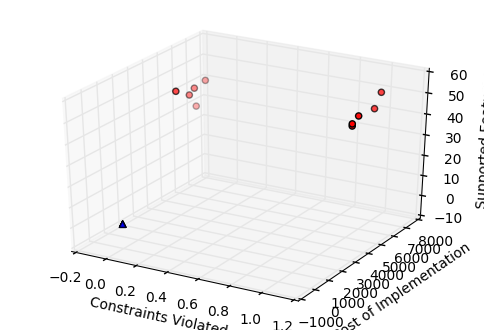

bankingsw
Number of decisions :  146
Number of Features :  192
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
............................................................

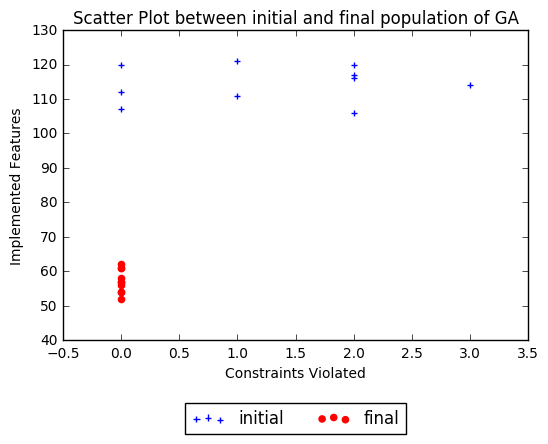

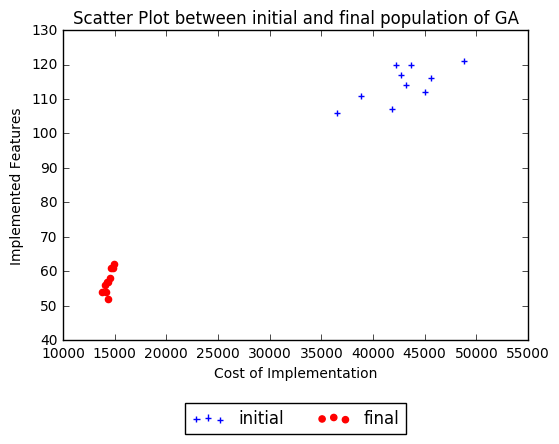

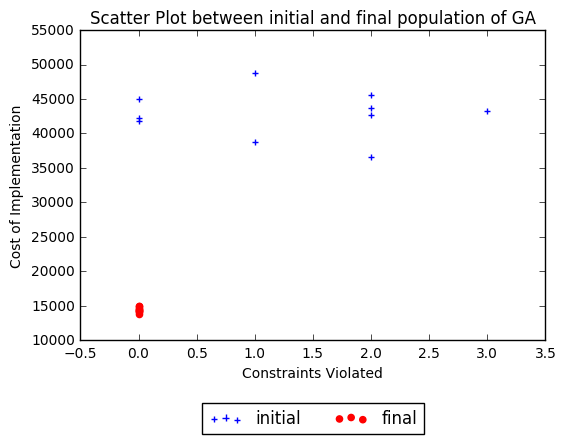

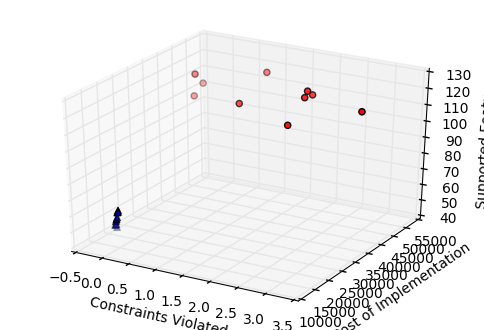

******************************************************************
[[0.0, 0.2916666666666667, 0.9861], [0.0, 0.2864583333333333, 0.9821], [0.0, 0.28125, 0.9061], [0.0, 0.3125, 1.7247], [0.0, 0.3072916666666667, 1.6566], [0.0, 0.2864583333333333, 0.9872], [0.0, 0.28125, 0.9352], [0.0, 0.5052083333333334, 3.4145], [0.0, 0.4947916666666667, 3.4036], [0.0, 0.4739583333333333, 3.2963]]


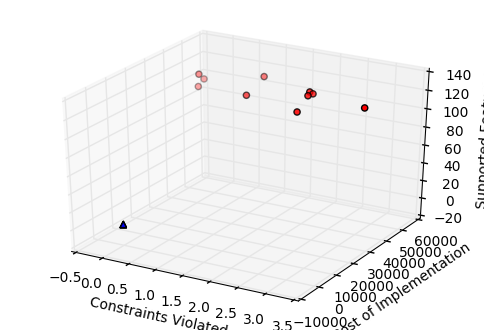

billing
Number of decisions :  74
Number of Features :  90
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
................................................................

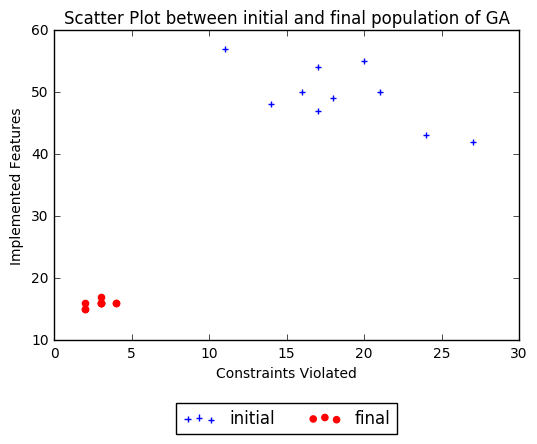

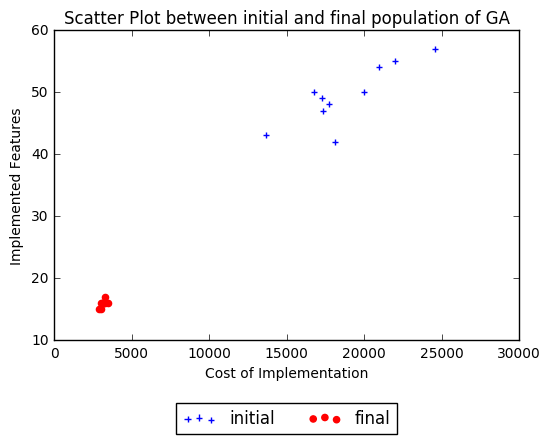

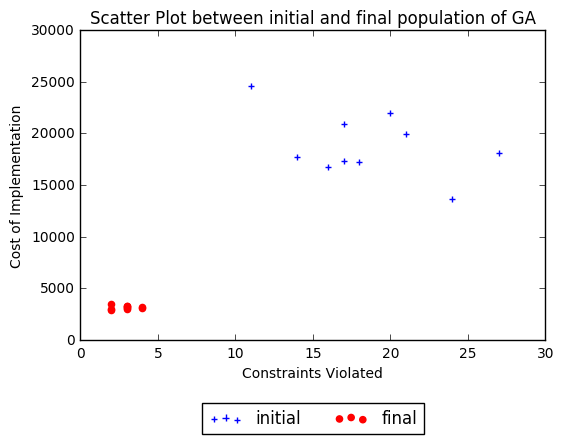

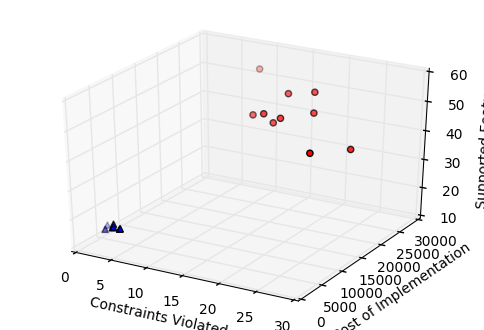

******************************************************************
[[0.2711864406779661, 0.35555555555555557, 0.7457], [0.3728813559322034, 0.4666666666666667, 1.4523], [0.2711864406779661, 0.35555555555555557, 0.7493], [0.3728813559322034, 0.4777777777777778, 1.5013], [0.3728813559322034, 0.4666666666666667, 1.4788], [0.3728813559322034, 0.45555555555555555, 1.4035], [0.2711864406779661, 0.3333333333333333, 0.6309], [0.2542372881355932, 0.3333333333333333, 0.716], [0.2542372881355932, 0.32222222222222224, 0.6446], [0.1016949152542373, 0.17777777777777778, 0.1913]]


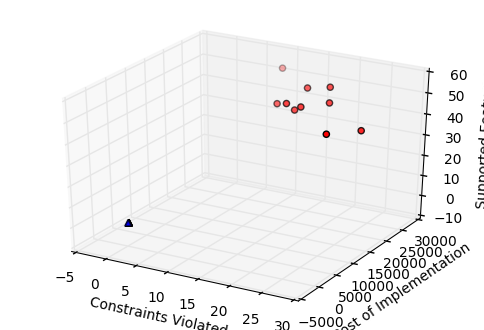

car
Number of decisions :  52
Number of Features :  91
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................

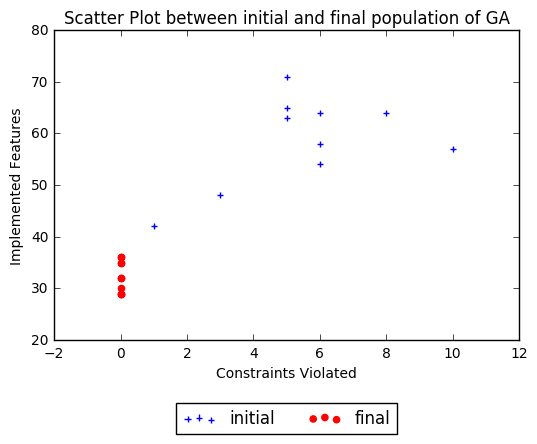

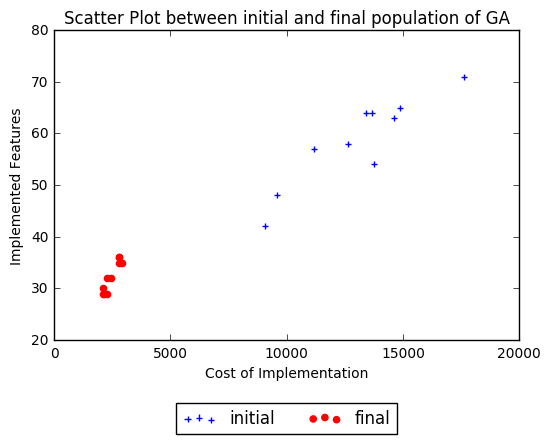

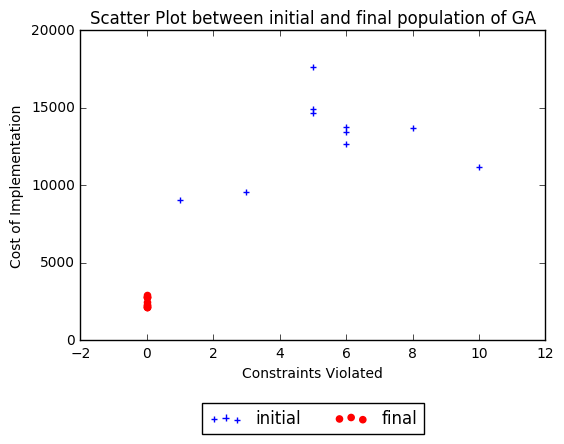

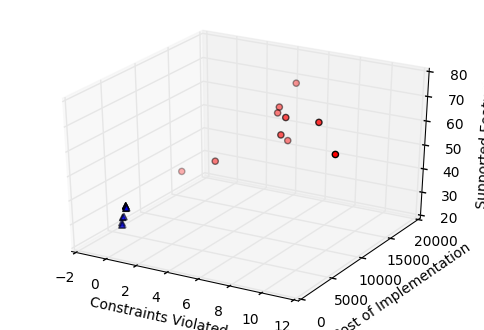

******************************************************************
[[0.0, 0.38461538461538464, 0.2851], [0.0, 0.3516483516483517, 0.2339], [0.0, 0.37362637362637363, 0.2834], [0.0, 0.37362637362637363, 0.2851], [0.0, 0.3516483516483517, 0.2452], [0.0, 0.34065934065934067, 0.2339], [0.14285714285714285, 0.5714285714285714, 0.7027], [0.0, 0.3956043956043956, 0.3086], [0.0, 0.38461538461538464, 0.2964], [0.14285714285714285, 0.5824175824175825, 0.7088]]


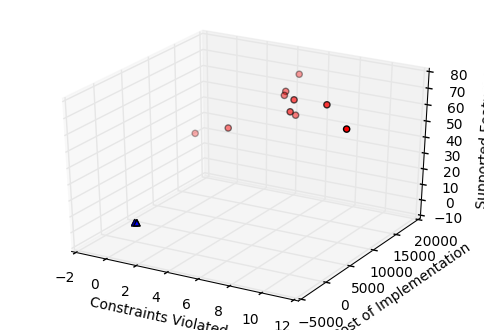

classicshell
Number of decisions :  48
Number of Features :  79
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
...........................................................

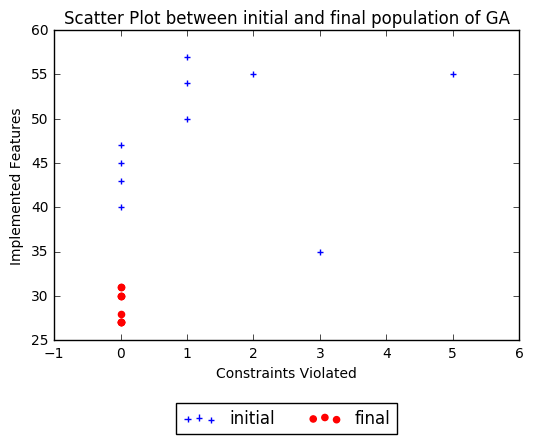

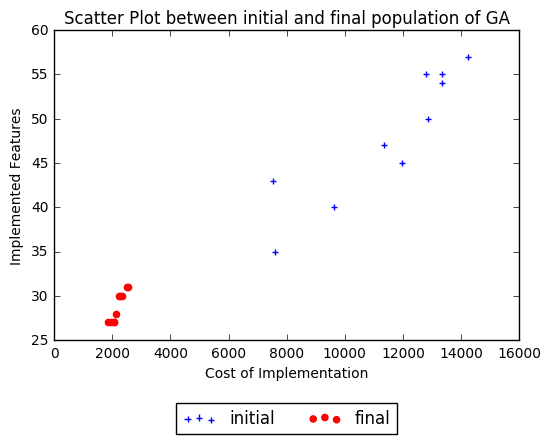

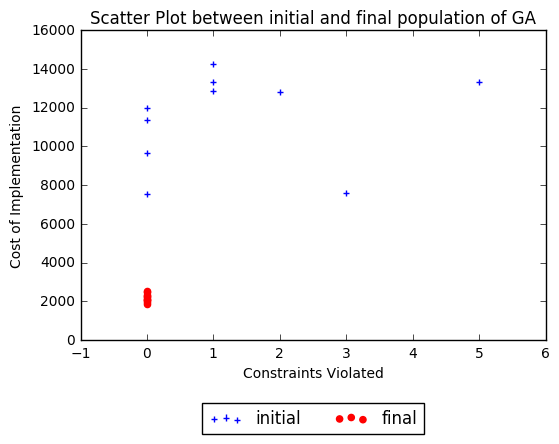

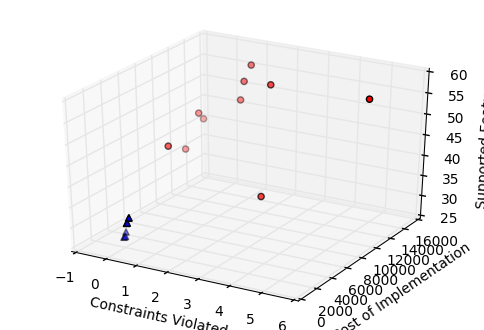

******************************************************************
[[0.0, 0.5443037974683544, 0.5018], [0.0, 0.5443037974683544, 0.5033], [0.0, 0.5063291139240507, 0.4599], [0.0, 0.5063291139240507, 0.4614], [0.0, 0.5063291139240507, 0.466], [0.0, 0.5063291139240507, 0.469], [0.0, 0.4936708860759494, 0.4415], [0.0, 0.4810126582278481, 0.5582], [0.0, 0.4810126582278481, 0.5586], [0.0, 0.4936708860759494, 0.5858]]


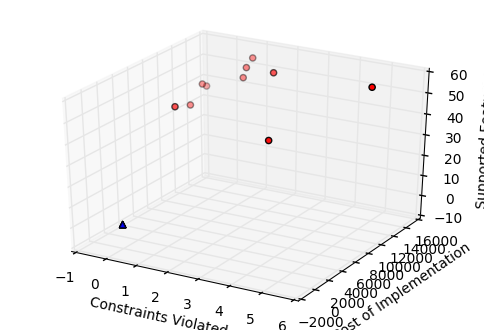

enterprisesys
Number of decisions :  342
Number of Features :  385
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
........................................................

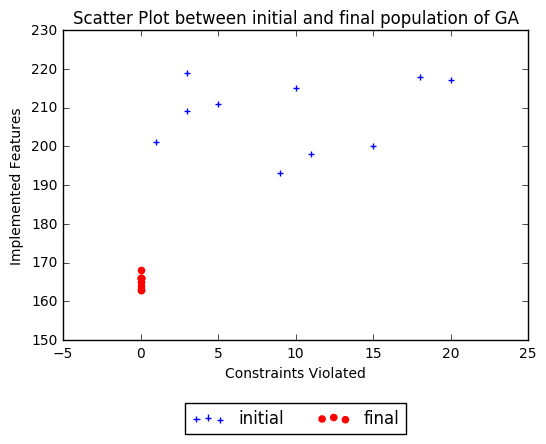

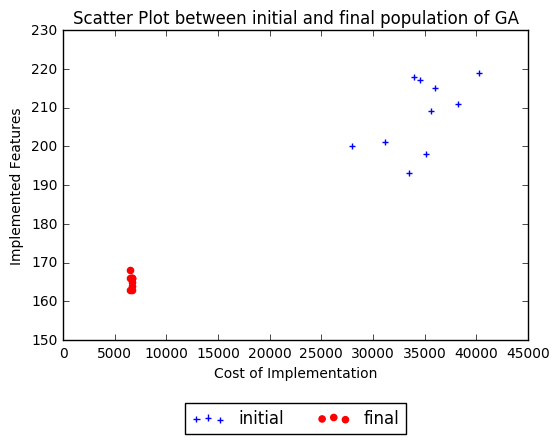

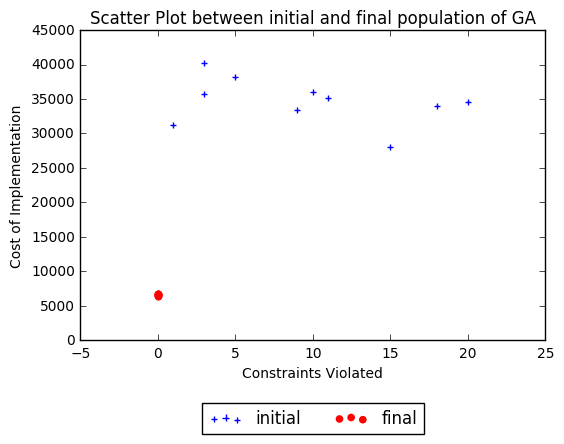

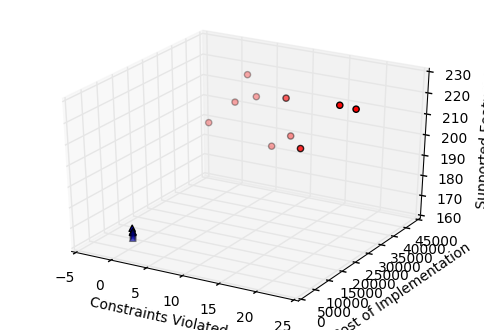

******************************************************************
[[0.005208333333333333, 0.43896103896103894, 0.5563], [0.0, 0.44935064935064933, 0.6055], [0.0, 0.44935064935064933, 0.6055], [0.0, 0.44415584415584414, 0.5942], [0.010416666666666666, 0.44415584415584414, 1.3008], [0.005208333333333333, 0.44155844155844154, 0.5569], [0.0, 0.44155844155844154, 0.5942], [0.010416666666666666, 0.5246753246753246, 2.5664], [0.005208333333333333, 0.43636363636363634, 0.5563], [0.010416666666666666, 0.5272727272727272, 2.6133]]


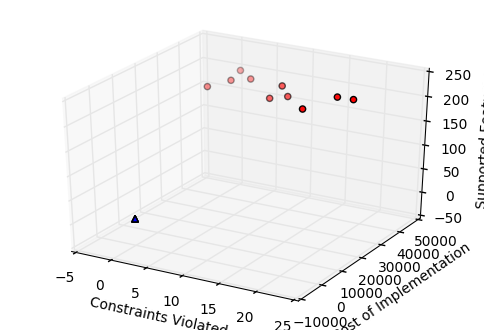

smarthome
Number of decisions :  36
Number of Features :  66
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
....................................................................................................
..........
..................................................
..............................................................

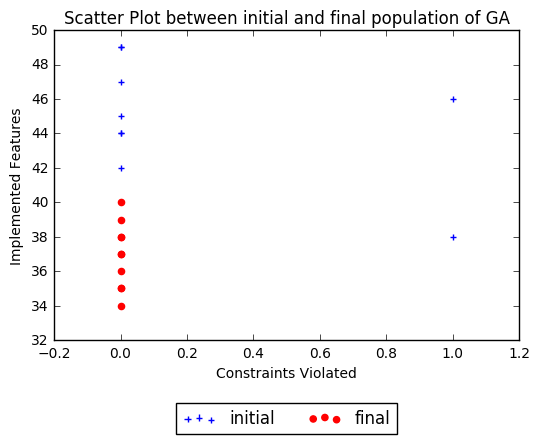

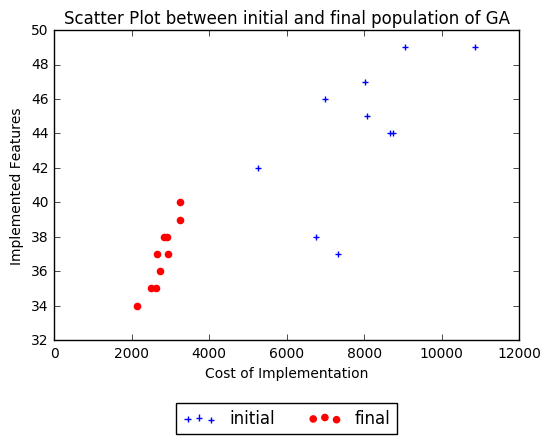

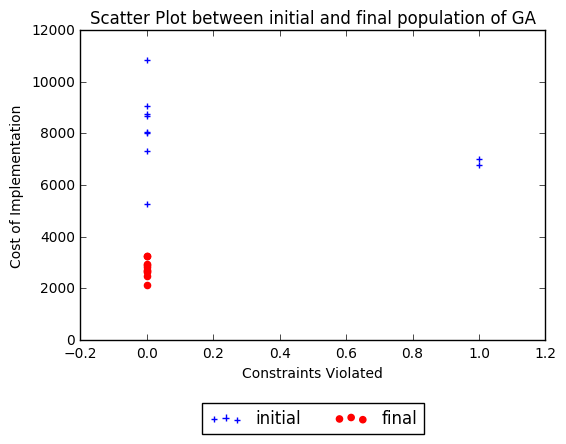

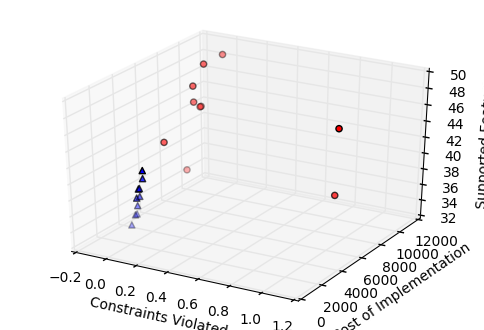

******************************************************************
[[0.0, 0.6060606060606061, 0.3087], [0.0, 0.5757575757575758, 0.2753], [0.0, 0.6363636363636364, 0.3876], [0.0, 0.5909090909090909, 0.2869], [0.0, 0.5757575757575758, 0.2793], [0.0, 0.5606060606060606, 0.2535], [0.0, 0.6515151515151515, 0.4439], [0.0, 0.6363636363636364, 0.3943], [0.0, 0.6212121212121212, 0.3727], [0.0, 0.5909090909090909, 0.2953]]


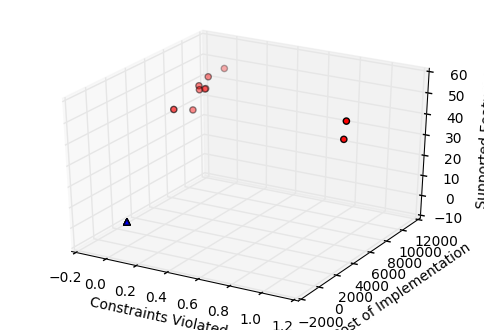

In [306]:
models = ['Linux.xml', 'Bike.xml', 'eCommerce.xml', 'bankingsw.xml',
          'billing.xml', 'car.xml', 'classicshell.xml', 'enterprisesys.xml', 'smarthome.xml']

#replace this with models after test
models_temp = ['eCommerce.xml']


problems = [Problem(splot, 10000) for splot in models]
for problem in problems:
    
    problem.details()
    
    test_gens=[10,50,100]
    tests = {t: [] for t in test_gens}
    tests[0]=[]#For initial population
    repeats = 10
    pop_size=10
    for _ in range(repeats):
        init_population = populate(problem, pop_size)
        for gen in test_gens:
            initial, final = ga(problem=problem, pop_size=pop_size, gens=gen, dom_func=cdom)
            tests[gen].append(normalize(problem, final))
        tests[0].append(normalize(problem, init_population))
    
    print("Initial")
    avg_and_variance(initial)
    print("Final")
    avg_and_variance(final)
    
    plot_pareto(initial, final)
    plot_3D(initial, final)
    
    #print(tests)
    print('******************************************************************')
    reference=make_reference(problem, tests[10][0], tests[50][0], tests[100][0])
    print(reference)
    plot_3D(initial, final, finalObjectives=reference)